# Understanding clouds from satellite images

Studying cloud formations help understand and represent shallow clouds in climate models.These cloud patterns are manually classified by users into 4 categories Sugar,Flower,Fish,Gravel.
The goal of this project is to identify if we have the flower pattern in the image or not and treat it as a binary image classification problem.

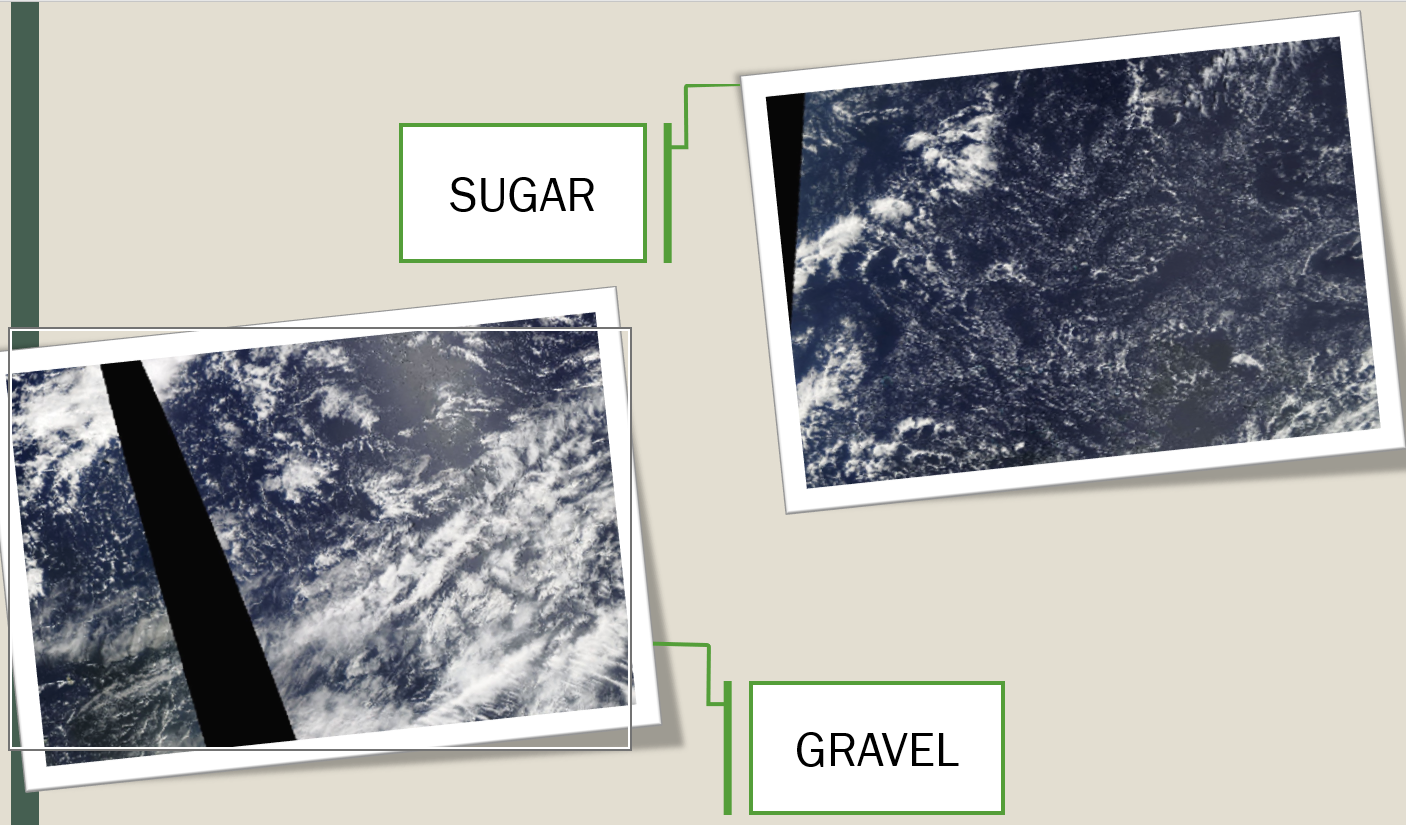

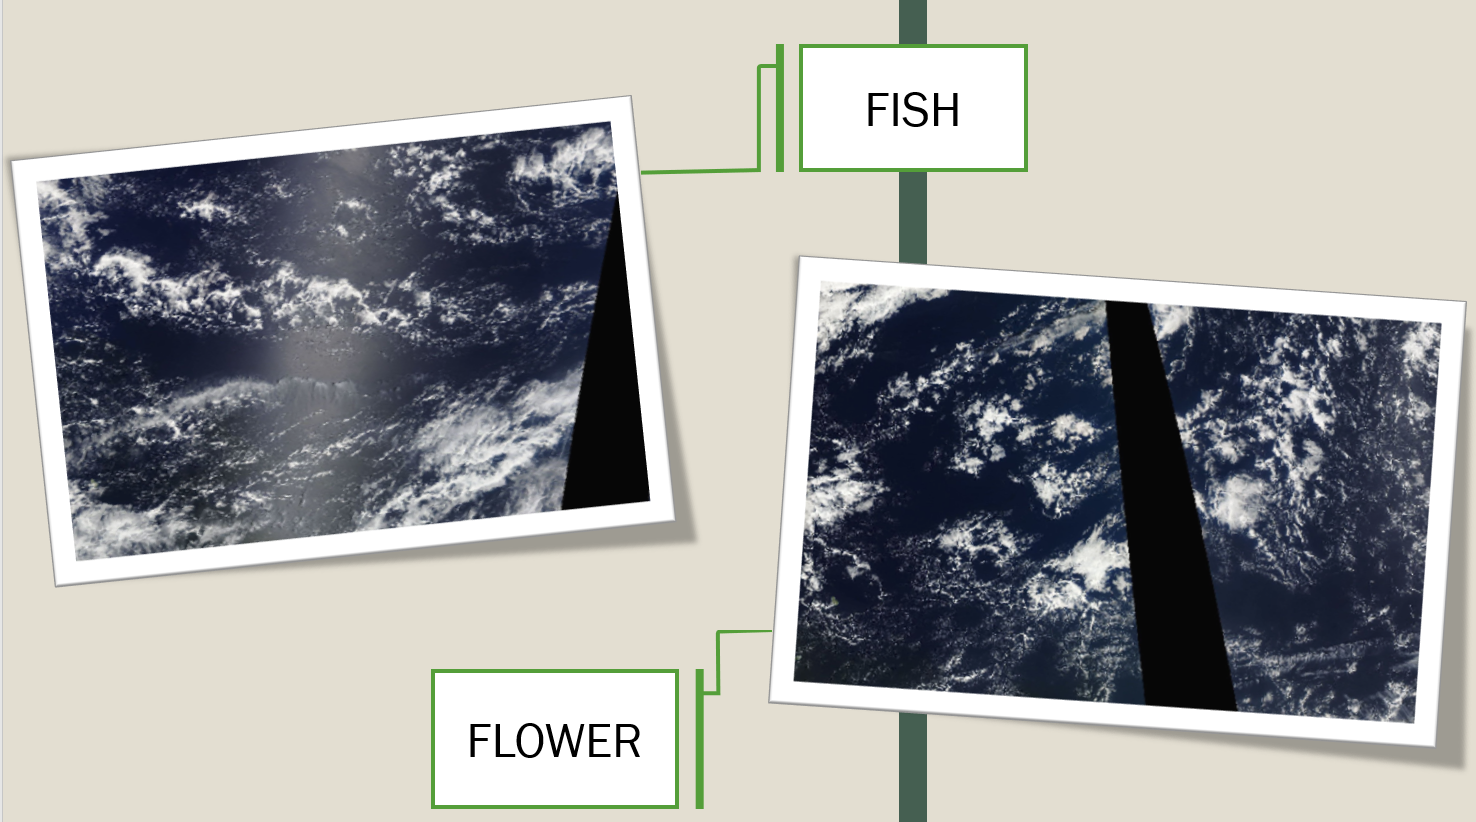

Since it is a image classification problem we would like to use transfer learning to reduce the training time i.e. it would take much longer time to train all the layers of a deep neural network rather than just training few layers at the end of the neural network and reusing the weights of the initial layers of the network.
The number of layers that needs to be retrained on the custom dataset is a hyperparameter.

2 pre trained models i.e inceptionv3 and resnet were selected to address the problem.After initial analysis i.e. comparing the training and test classification metrics of both the pre trained models on this custom dataset, it was found that resnet performed better.Hence resnet is used below to demonstrate the binary classification of cloud images into flower and no flower in this project.

In [0]:
!pip install -q keras

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

#### Install the necessary libraries and mount your google drive so that data for training/testing can be accessed

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Define generators from keras to preprocess the images

In [0]:
data_generator = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range = 0.4,
                                   height_shift_range = 0.4,
                                   validation_split = 0.2 
                                   )

image_size = 224
batch_size = 10
train_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Desktop/data/train/',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Desktop/data/test/',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')

num_classes = len(train_generator.class_indices)

Found 1305 images belonging to 2 classes.
Found 1121 images belonging to 2 classes.


In [0]:
from tensorflow.python.keras.applications.resnet import ResNet50

base_model = ResNet50(
    include_top=False, 
    pooling='avg', 
    weights='imagenet',
    input_shape=(32, 32, 3))

print(len(base_model.layers))

# for layer in base_model.layers:
#     layer.trainable = False


176


In [0]:
base_model.summary()

###### import the pre trained model from tensorflow

In [0]:
##import the base model without the top layers and add your own top layers(3 dense layers as shown below)
##freeze the base layers and train the custom added top layers only
from tensorflow.python.keras.applications.resnet import ResNet50

base_model = ResNet50(
    include_top=False, 
    pooling='avg', 
    weights='imagenet',
    input_shape=(image_size, image_size, 3))

for layer in base_model.layers:
    layer.trainable = False

res50_model = Sequential()

res50_model.add(base_model)
res50_model.add(Flatten())
res50_model.add(BatchNormalization())
res50_model.add(Dense(2048, activation='relu'))
res50_model.add(BatchNormalization())
res50_model.add(Dense(1024, activation='relu'))
res50_model.add(BatchNormalization())
res50_model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 4s 0us/step


In [0]:
##train the model for 20 epochs with the learning rate of 0.005
learning_rate = 0.005
n_epochs = 20

In [0]:
from tensorflow.python.keras.optimizers import Nadam

optimizer = Nadam(lr=learning_rate)

In [0]:
res50_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### location to save the trained model

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

save_cb = ModelCheckpoint('/content/drive/My Drive/dense_cloud_model.h5',
                          save_best_only=True,
                          monitor='val_acc',
                          mode='auto')

In [0]:
import os
train_count = sum([len(files) for r, d, files in os.walk("/content/drive/My Drive/data/train")])
val_count = sum([len(files) for r, d, files in os.walk("/content/drive/My Drive/data/test")])

In [0]:
##the class distribution is balanced in our case but we want to emphasize on false positives 
##hence we give a higher class weight to 0 as compared to 1
class_weight = {0 : 2.5, 1: 1.}

history = res50_model.fit_generator(
    train_generator,
    steps_per_epoch=int(train_count/batch_size) + 1,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=val_count // batch_size,
    class_weight=class_weight,
    callbacks=[save_cb])

Epoch 1/20
131/131 [==============================] - 1536s 12s/step - loss: 1.8650 - acc: 0.7510 - val_loss: 0.8173 - val_acc: 0.7973
Epoch 2/20
131/131 [==============================] - 183s 1s/step - loss: 1.9234 - acc: 0.7448 - val_loss: 1.7171 - val_acc: 0.6179
Epoch 3/20
131/131 [==============================] - 178s 1s/step - loss: 1.7055 - acc: 0.7686 - val_loss: 0.7831 - val_acc: 0.7982
Epoch 4/20
131/131 [==============================] - 178s 1s/step - loss: 1.3185 - acc: 0.7808 - val_loss: 1.2026 - val_acc: 0.8107
Epoch 5/20
131/131 [==============================] - 177s 1s/step - loss: 1.1322 - acc: 0.7839 - val_loss: 0.5639 - val_acc: 0.7866
Epoch 6/20
131/131 [==============================] - 175s 1s/step - loss: 0.9445 - acc: 0.7923 - val_loss: 0.6788 - val_acc: 0.8098
Epoch 7/20
131/131 [==============================] - 172s 1s/step - loss: 0.8166 - acc: 0.7900 - val_loss: 1.1991 - val_acc: 0.7982
Epoch 8/20
131/131 [==============================] - 180s 1s/step 

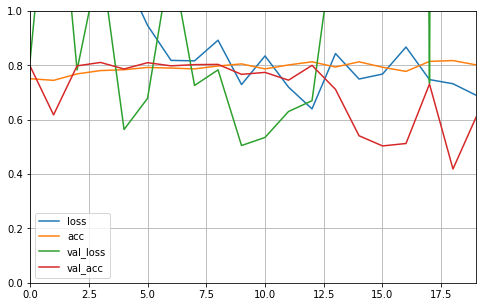

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

#### plotting the training and validation accuracy and loss

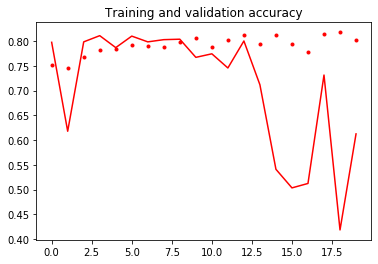

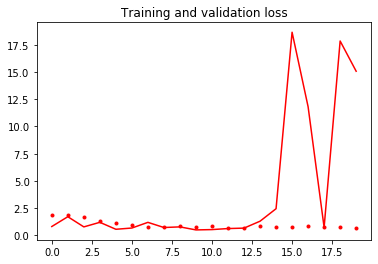

In [0]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

#### function to make predictions

In [0]:
def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("Noflower", "flower")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [0]:
cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
from tensorflow.python.keras.models import load_model
MODEL_FILE = 'dense_cloud_model.h5'
model = load_model(MODEL_FILE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
cd '/content/drive/My Drive/Colab Notebooks/Desktop/data'

/content/drive/My Drive/Colab Notebooks/Desktop/data


#### testing on few images to identify both the classes

array([0.0063415, 0.9936585], dtype=float32)

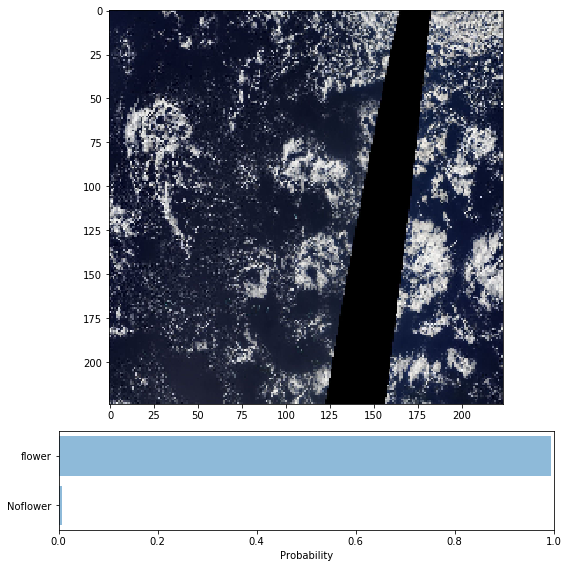

In [0]:
img = image.load_img('test/1/0a5d418.jpg', target_size=(224, 224))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([3.6284747e-04, 9.9963713e-01], dtype=float32)

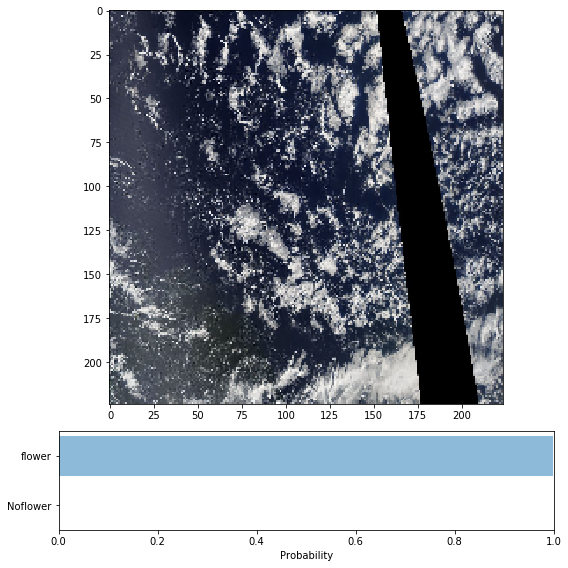

In [0]:

img = image.load_img('test/1/0a89811.jpg', target_size=(224,224))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([0.9638811 , 0.03611892], dtype=float32)

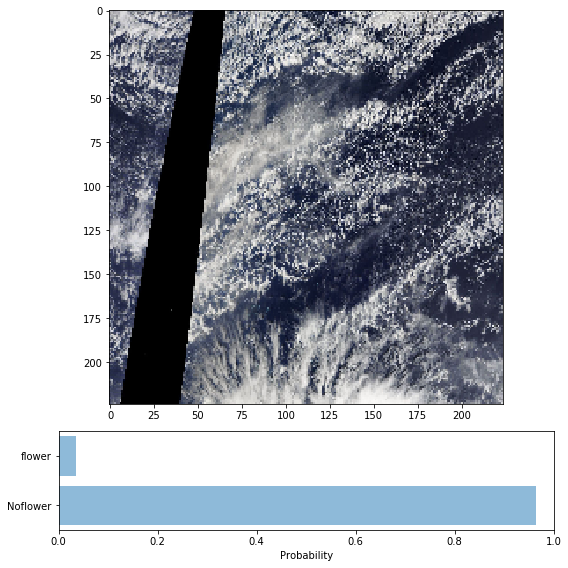

In [0]:
img = image.load_img('test/0/0a515e3.jpg', target_size=(224,224))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [0]:
cd '/content/drive/My Drive/Colab Notebooks/Desktop/data/test/0'

/content/drive/My Drive/Colab Notebooks/Desktop/data/test/0


In [0]:
import os
import pandas as pd

In [0]:
ls =[]
for root, dirs, files in os.walk(".", topdown=False):
  for file in files:
      img = image.load_img(file, target_size=(224,224))
      preds = predict(model, img)
      ls.append(preds)
      #print(preds)

In [0]:
cd '/content/drive/My Drive/Colab Notebooks/Desktop/data/test/1'

/content/drive/My Drive/Colab Notebooks/Desktop/data/test/1


#### create a dataframe with predictions to generate a confusion matrix diagram

In [0]:
ls_1 =[]
for root, dirs, files in os.walk(".", topdown=False):
  for file in files:
      img = image.load_img(file, target_size=(224,224))
      preds = predict(model, img)
      ls_1.append(preds)
      #print(preds)

In [0]:
df_1 = pd.DataFrame(ls_1)
df_1.columns = ['Noflower','Flower']
df_1.head()

,Noflower,Flower
0,2.138598e-03,0.997861
1,3.633094e-08,1.000000
2,3.223903e-06,0.999997
3,3.269502e-01,0.673050
4,5.060651e-01,0.493935


In [0]:
df_1['output'] = df_1.apply(lambda x: 1 if x['Flower'] > x['Noflower'] else 0,axis=1)
df_1['actual'] = 1
df_1.head()

,Noflower,Flower,output,actual
0,2.138598e-03,0.997861,1,1
1,3.633094e-08,1.000000,1,1
2,3.223903e-06,0.999997,1,1
3,3.269502e-01,0.673050,1,1
4,5.060651e-01,0.493935,0,1


In [0]:

df = pd.DataFrame(ls)
df.columns = ['Noflower','Flower']
df.head()

,Noflower,Flower
0,0.626401,0.373599
1,0.000003,0.999997
2,0.002529,0.997471
3,0.002139,0.997861
4,0.013462,0.986538


In [0]:
df['output'] = df.apply(lambda x: 1 if x['Flower'] > x['Noflower'] else 0,axis=1)
df['actual'] = 0
df.head()

,Noflower,Flower,output,actual
0,0.626401,0.373599,0,0
1,0.000003,0.999997,1,0
2,0.002529,0.997471,1,0
3,0.002139,0.997861,1,0
4,0.013462,0.986538,1,0


In [0]:
final_data = pd.concat([df,df_1])

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = list(unique_labels(y_true, y_pred))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[ 66 145]
 [ 81 829]]


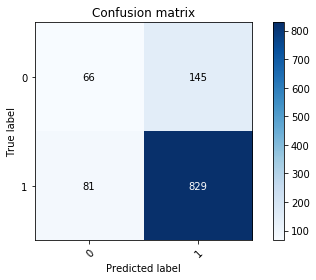

In [0]:
y_pred = np.array(final_data['output'])
y_test = np.array(final_data['actual'])
plot_confusion_matrix(y_test,y_pred, classes=['Noflower','flower'],title='Confusion matrix')

#### classification metrics to evaluate the performance of model

In [0]:
from sklearn.metrics import accuracy_score,precision_score,recall_score


In [0]:
print("Precision of the test data : ",precision_score(y_pred,y_test))
print("Recall of test data: ",recall_score(y_pred,y_test))
print("Accuracy of test data: ",accuracy_score(y_pred,y_test))

Precision of the test data :  0.910989010989011
Recall of test data:  0.851129363449692
Accuracy of test data:  0.7983942908117752


#### Conclusion

As shown above we have a good precision and recall for the model.Hence we can use it on the real dataset and compare it with user classified images in the real world before deploying it to production.